In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Quickstart

If you already have your measurement set ready, jump right to the [Reading Visibilites](https://visread.readthedocs.io/en/latest/tutorials/plot_baselines.html#Reading-Visibilities) section of the tutorial (reading visibilities is quick)!

If you don't have a measurment set, we'll walk through how you can create a mock one using CASA's *simobserve* task. Alternatively, you can download the mock measurement sets (``logo_cube.noise.ms.tar.gz``) from [Zenodo](https://zenodo.org/record/4711811), and skip right to the "Reading Visibilites" section, too.

## Creating a mock measurement set

### Examine the sky brightness distribution

We'll use a mock sky brightness distribution of the ALMA logo. The FITS cube is available on [Zenodo](https://zenodo.org/record/4711811/files/logo_cube.fits). Just to orient ourselves, let's take a look at a few channels of it first.

In [3]:
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
from IPython.display import HTML
from astropy.utils.data import download_file

In [4]:
fits_path = download_file(
    "https://zenodo.org/record/4711811/files/logo_cube.fits",
    cache=True,
    pkgname="visread",
)

In [5]:
hdul = fits.open(fits_path)
header = hdul[0].header
data = 1e3 * hdul[0].data  # mJy/pixel
# get the coordinate labels
nx = header["NAXIS1"]
ny = header["NAXIS2"]
# RA coordinates
CDELT1 = 3600 * header["CDELT1"]  # arcsec (converted from decimal deg)
CRPIX1 = header["CRPIX1"] - 1.0  # Now indexed from 0
# DEC coordinates
CDELT2 = 3600 * header["CDELT2"]  # arcsec
CRPIX2 = header["CRPIX2"] - 1.0  # Now indexed from 0
RA = (np.arange(nx) - nx / 2) * CDELT1  # [arcsec]
DEC = (np.arange(ny) - ny / 2) * CDELT2  # [arcsec]
# extent needs to include extra half-pixels.
# RA, DEC are pixel centers
ext = (
    RA[0] - CDELT1 / 2,
    RA[-1] + CDELT1 / 2,
    DEC[0] - CDELT2 / 2,
    DEC[-1] + CDELT2 / 2,
)  # [arcsec]
freqs = header["CRVAL3"] + np.arange(header["NAXIS3"]) * header["CDELT3"]  # [Hz]
nchan = len(data)
norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(data))

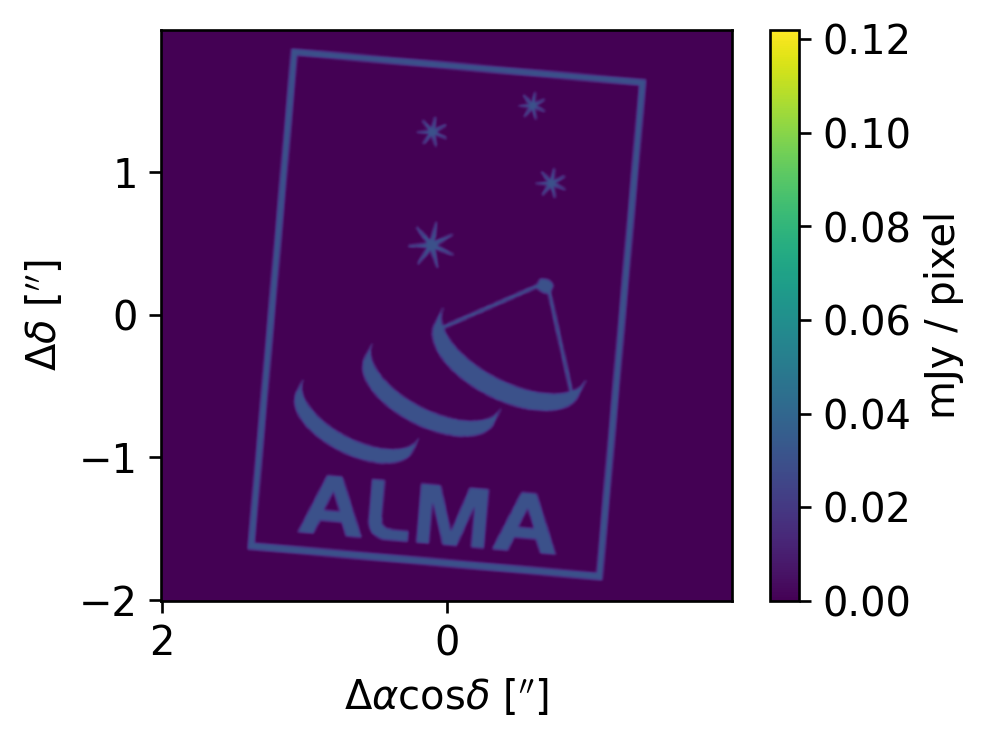

In [6]:
fig, ax = plt.subplots(nrows=1, figsize=(4.5, 3.5))
fig.subplots_adjust(left=0.2, bottom=0.2)

ims = []

for i in range(nchan):
    im = ax.imshow(data[i], extent=ext, origin="lower", animated=True, norm=norm)

    if i == 0:
        cb = plt.colorbar(im, label="mJy / pixel")
        ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
        ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

    ims.append([im])

And if you'd like to scroll through the channels (a few km/s total)

In [7]:
ani = animation.ArtistAnimation(fig, ims, interval=200, blit=False, repeat_delay=1000)
HTML(ani.to_jshtml(default_mode="loop"))

## Use simobserve to create a mock measurement set

Now that we're comfortable with what we're looking at, let's use the `simobserve` task from CASA to actually produce a mock measurement set.

In [8]:
import casatasks

In [9]:
# For the purposes of tutorial hygine, we'll create a temporary directory to store the measurement set.
# In real life, you could just simplify these lines to use your current output directory
import tempfile

temp_dir = tempfile.TemporaryDirectory()
curdir = os.getcwd()
os.chdir(temp_dir.name)

More information on the `simobserve` task is available in the [CASA docs](https://casa.nrao.edu/casadocs-devel/stable/simulation/introduction). Briefly, what we're doing here is using the ALMA logo cube as a sky model (inheriting the brightness, location, and frequency spacing from the FITS header) and then "observing" it with a fake interferometer for 1 hour. We're using the Cycle 7 43-7 array configuration. Configuration files are available for download from the [ALMA site](https://almascience.nrao.edu/tools/casa-simulator).

In [10]:
casatasks.simobserve(
    skymodel=fits_path,
    hourangle="transit",
    totaltime="3600s",
    thermalnoise="tsys-atm",
    graphics="none",
    overwrite=True,
    obsmode="int",  # interferometer
    antennalist=curdir + "/" + "../../tests/alma.cycle7.7.cfg",
)

In [11]:
os.chdir(curdir)
ms_path = temp_dir.name + "/sim/sim.alma.cycle7.7.ms"
print(ms_path)

/tmp/tmpyspbf5c2/sim/sim.alma.cycle7.7.ms


## Reading Visibilities
Now that we have a measurement set, lets demonstrate how we can use the `visread` package to interact with these visibilities. More information on these routines is available under the [API](https://visread.readthedocs.io/en/latest/api.html) section of the `visread` docs.

In [12]:
import visread

In [13]:
cube = visread.read(ms_path)

In [14]:
# Now we have access to the baselines via the `.uu` and `.vv` attributes.
print(cube.uu.shape)
print(cube.vv.shape)

(9, 325080)
(9, 325080)


We see that these are two dimensional arrays of shape (nchan, nvis).

Let's plot up the baseline coverage for the first channel of the cube (index `0`).

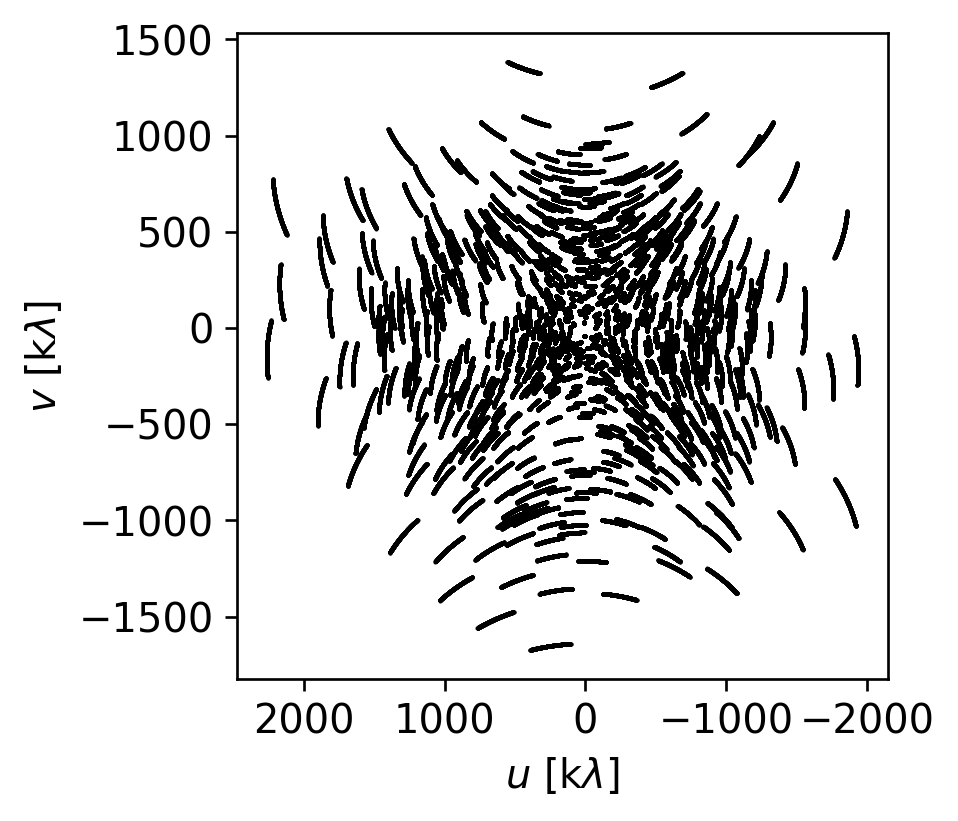

In [15]:
fig, ax = plt.subplots(nrows=1, figsize=(3.5, 3.5))

ax.scatter(cube.uu[0], cube.vv[0], s=1.5, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
ax.invert_xaxis()

We can also plot the visibility amplitude as a function of radial baseline

In [16]:
qq = np.sqrt(cube.uu[0] ** 2 + cube.vv[0] ** 2)
amp = np.sqrt(
    cube.data_re[0] ** 2 + cube.data_im[0] ** 2
)  # amplitude of complex number

Text(0, 0.5, 'Amplitude [Jy]')

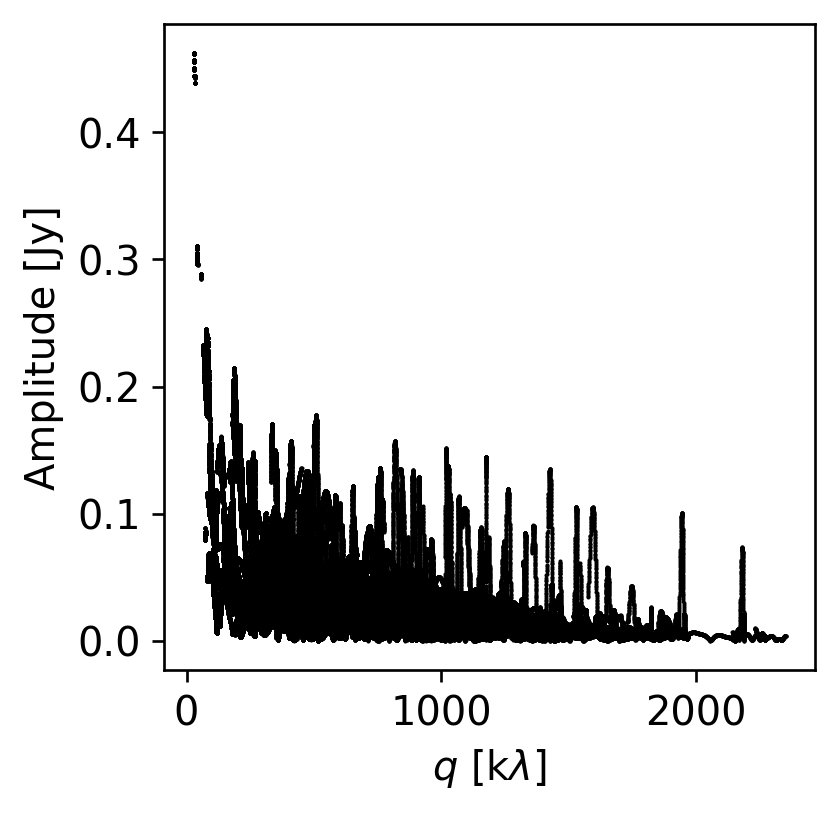

In [17]:
fig, ax = plt.subplots(nrows=1, figsize=(3.5, 3.5))
ax.scatter(qq, amp, s=1.5, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$q$ [k$\lambda$]")
ax.set_ylabel(r"Amplitude [Jy]")

If you need them, the visibility weights are accessible via `cube.weight`.

In [18]:
temp_dir.cleanup()  # cleanup